In [0]:
# this is required for running the notebook on colab 
# this is the link to our pytorch notebook on colab: https://colab.research.google.com/drive/1_37hFKHZ7SQh3NbZq0vxwN__yWm4LkTZ#scrollTo=kOyiIGIpi4yQ
!pip3 install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip3 install -q torchvision

In [0]:
# COMP 551 Final Project
# Adversarial Dropout for Supervised and Semi-Supervised Learning
# Authors: Alexander Bratyshkin, David Lougheed, Camilo Garcia

In [0]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd.gradcheck import zero_gradients
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import time
from math import ceil
import random
import cv2


In [0]:
# check if we have gpu power
use_cuda = torch.cuda.is_available()

# fix random seeds for reproducability
random.seed(15751)
torch.manual_seed(15751)

if use_cuda:
    torch.cuda.manual_seed_all(15751)

np.random.seed(15751)


In [0]:
# hyper parameters
num_epochs = 3
batch_size = 64
learning_rate = 0.001
delta = 0.005


In [6]:
# load relevant MNIST datasets, included in pytorch already

# training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=batch_size, shuffle=True, num_workers=4)
# test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, num_workers=4)

Processing...
Done!


In [0]:
# implementation of both loss functions used in the original paper

# this one was used for the calculation of the temporary loss 
# during the adversarial training step
def kl_divergence(q_logit, p_logit):
  q = F.softmax(q_logit)
  
  return torch.mean(torch.sum(q * F.log_softmax(q_logit))) - torch.mean(torch.sum(q * F.log_softmax(p_logit.float())))

# implemented but never used formally because we ballin'  
def qe_loss(logit1, logit2):
  logit1 = F.softmax(logit1)
  logit2 = F.softmax(logit2.float())
  
  return torch.mean((logit1 - logit2)*(logit1 - logit2))

In [0]:
def build_adversarial_matrix(x, delta, jacobian_matrix):  
  np_adversarial_matrix = x.data.cpu().numpy()
  np_jacobian_matrix = jacobian_matrix.data.cpu().numpy()
    
  for i in range(len(np_adversarial_matrix)): 
    e_sample = np.random.randint(2, size=128*3*3)  # Dropout with p=0.5
    np_adversarial_matrix[i][:] = get_adversarial_dropout(e_sample, delta, np_jacobian_matrix[i])

  result_matrix = Variable(torch.from_numpy(np_adversarial_matrix))
  
  if use_cuda:
    result_matrix = Variable(torch.from_numpy(np_adversarial_matrix)).cuda()
  
  return result_matrix

def get_adversarial_dropout_slow(sampled_mask, delta, jacobian):
  """
  The following is a verbatim implementation of Algorithm 1 as described by
  Park et al in the paper of interest. It was found to be too slow for
  practical usage, but is included as a comparison / sanity check for the
  performance-optimized version and for completeness.
  """
  
  layer_size = 128*3*3
  constraint = delta * layer_size  # As defined by Park et al.
  
  z = abs(jacobian)
  e_adv = np.copy(sampled_mask)
  i_indices = np.argsort(z)
  
  d = 0
  while (np.linalg.norm(sampled_mask - e_adv) <= constraint and d < layer_size): 
    if(e_adv[i_indices[d]] == 0 and jacobian[i_indices[d]] > 0):
      e_adv[i_indices[d]] = 1
    elif(e_adv[i_indices[d]] == 1 and jacobian[i_indices[d]] < 0):
      e_adv[i_indices[d]] = 0
    
    d += 1
    
  return e_adv
  

def get_adversarial_dropout(sampled_mask, delta, jacobian):
  """
  The following is a performance-optimized version of Algorithm 1 as described
  by Park et al in the paper of interest. Instead of the described while loop,
  bitmasks and bitwise operations are used to increase training speed.
  """
  
  layer_size = 128*3*3
  constraint = delta * layer_size  # As defined by Park et al.
  
  e_adv = np.copy(sampled_mask)
  i_indices = np.argsort(abs(jacobian))
  # Store inverse map of sorted indices as well, to get back original order.
  i_indices_inv = np.argsort(i_indices)

  # REPLACEMENT BOOLEAN MASK (Determines which will be adversarially changed):
  # 1 if sample is 0 (false) and jacobian > 0 (true)
  # or sample is 1 (true) and jacobian < 0 (false),
  # making sure to ignore any 0 gradients:
  replacement_mask = np.bitwise_and(np.bitwise_xor(e_adv.astype(bool), jacobian > 0), jacobian != 0)
  
  # Find top-K neurons to flip on or off using the replacement mask sorted
  # by the order specified in the algorithm (absolute values of the Jacobian
  # vector sorted small to large).
  rm_sorted = replacement_mask[i_indices]
  rm_nonzero = np.nonzero(rm_sorted)[0]
  rm_nonzero = rm_nonzero[:min(ceil(constraint ** 2), len(rm_nonzero))]
  rm_nonzero_mask = np.zeros(layer_size)
  rm_nonzero_mask[rm_nonzero] = 1
  rm_nonzero_mask = rm_nonzero_mask[i_indices_inv].astype(bool)

  # 1 if e_adv = 1 and no replace (false), 0 otherwise
  # 0 if e_adv = 0 and no replace (false), 1 otherwise
  e_adv = np.bitwise_xor(sampled_mask.astype(bool), rm_nonzero_mask).astype(int)
    
  return e_adv.astype(int)
     

In [0]:
# model for training MNIST, including adversarial dropout
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        nn.Dropout2d(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        nn.Dropout2d(),
        nn.Conv2d(64, 128, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    )
    

  def forward(self, x):
    out = self.features(x)    
    return out.view(out.size(0), 128*3*3)
  
# model for training MNIST, including adversarial dropout
class Linear(nn.Module):
  def __init__(self):
    super(Linear, self).__init__()
    
    self.first_linear = nn.Linear(128*3*3, 625)
    
    self.classifier = nn.Sequential(
      self.first_linear,
      nn.ReLU(inplace=True),
      nn.Linear(625, 10),
    )


  def forward(self, x):
    x = self.classifier(x)
    return x

In [0]:
# instantiate convolutional & linear part of CNN separately 
model_pre_grad = CNN()
model_post_grad = Linear()
if use_cuda:
    model_pre_grad.cuda()
    model_post_grad.cuda()
    

In [0]:
# used for growth visualization
test_accuracy_per_epoch = []
test_loss_per_epoch = []

# used for sparsity visualization
weights_per_epoch = []

In [0]:
opt = torch.optim.Adam(list(model_post_grad.parameters()) + list(model_pre_grad.parameters()), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# IMPORTANT #
# set use_adversarial to true if you want to train the model with adversarial dropout
# set use_adversarial to false if you want to train the model with regular dropout 
# IMPORTANT #
use_adversarial = True 

def train(epoch):
  model_post_grad.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if use_cuda:
        data, target = data.cuda(), target.cuda()
        
    data, target = Variable(data, requires_grad=True), Variable(target)

    output_pre_grad = model_pre_grad(data)
    
    if use_adversarial: 
      predict = model_post_grad(output_pre_grad)
      
      temp_loss = 0
      for i in range(len(predict)): 
        temp_loss += kl_divergence(predict[i], target[i])

      model_post_grad.zero_grad()

      dL_dh = torch.autograd.grad(temp_loss, output_pre_grad, retain_graph=True)[0]
      jacobian = output_pre_grad * dL_dh
      output_pre_grad = output_pre_grad * build_adversarial_matrix(output_pre_grad, delta, jacobian)

    else: 
      # Try using numpy random dropout for reproducability (so we can properly
      # compare with the adversarial dropout also generated with numpy's random
      # matrix generator.)
      np_output_pre_grad = output_pre_grad.data.cpu().numpy()
      random_dropout = np.random.randint(2, size=(len(np_output_pre_grad), 128*3*3))
      
      result_matrix = Variable(torch.from_numpy(random_dropout).float())
      if use_cuda:
        result_matrix = Variable(torch.from_numpy(random_dropout).float()).cuda()
      
      output_pre_grad = output_pre_grad * result_matrix
    
    predict = model_post_grad(output_pre_grad)
    
    loss = loss_func(predict, target)
    model_pre_grad.zero_grad()   
    model_post_grad.zero_grad()
    
    loss.backward()
    opt.step()
    if batch_idx % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))
  
  weights = list(map(lambda p: p.data, model_post_grad.first_linear.parameters()))[0].cpu().numpy()
  weights_per_epoch.append(weights)
            
def test():
  model_post_grad.train()
  test_loss = 0.0
  correct = 0
  for data, target in test_loader:
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)

    output_pre_grad = model_pre_grad(data)
    predict = model_post_grad(output_pre_grad)

    # sum up batch loss
    test_loss += loss_func(predict, target).data[0]
    # get the index of the max log-probability
    pred = predict.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  test_accuracy_per_epoch.append(test_accuracy)
  test_loss_per_epoch.append(test_loss)
  
  
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'
        .format(test_loss, correct, len(test_loader.dataset),
                test_accuracy))

In [13]:
for epoch in range(1, num_epochs):
  start_epoch = time.time()
  train(epoch)
  end_epoch = time.time()
  print("Epoch time: ", end_epoch - start_epoch)
  test()

Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.045301
Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.027263
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.081007
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.162174
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.050996
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.063503
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.039798
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.171076
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.256019
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.107568
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.180361
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.179602
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.103085
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.145554
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.031157
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.099849
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.084907
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.111174
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.137713
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.202287


In [14]:
pytorch_total_params = sum(p.numel() for p in model_post_grad.parameters() if p.requires_grad)
print(pytorch_total_params)

726885


Mean: 0.02506999298930168
Variance: 0.0004380300233606249


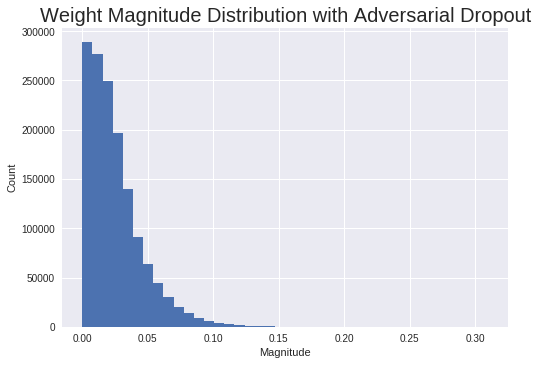

In [15]:
# plots used for sparsity claims 

abs_weights = abs(np.array(weights_per_epoch)).flatten()
plt.title(('Weight Magnitude Distribution with ' + ('Adversarial ' if use_adversarial else 'Regular ') + 'Dropout'), fontsize=20)
plt.hist(abs_weights, 40)
plt.xlabel('Magnitude')
plt.ylabel('Count')

# Print statistics related to sparsity
print('Mean: {}'.format(np.mean(abs_weights)))
print('Variance: {}'.format(np.var(abs_weights)))

No handles with labels found to put in legend.


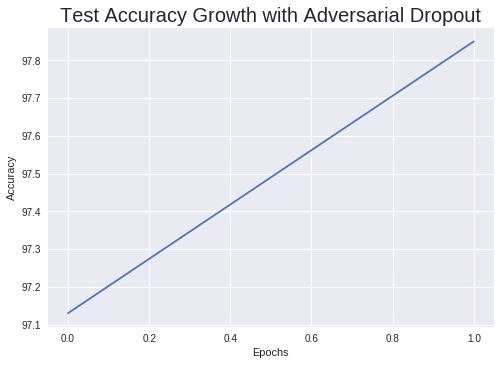

In [16]:
# plot for accuracy growth 
plt.title(('Test Accuracy Growth with '+('Adversarial' if use_adversarial else 'Regular ')+' Dropout'), fontsize=20)
plt.plot(range(0, num_epochs - 1), test_accuracy_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


No handles with labels found to put in legend.


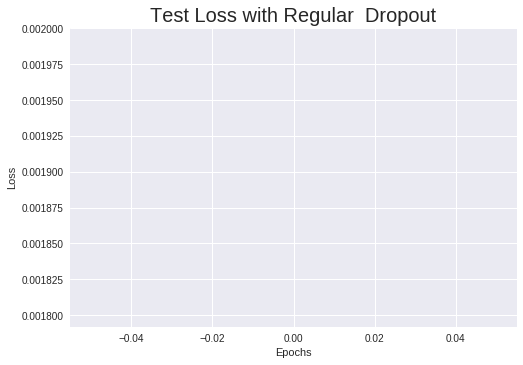

In [20]:
# plot for regular dropout 
plt.title(('Test Loss with '+('Adversarial' if use_adversarial else 'Regular ')+' Dropout'), fontsize=20)
plt.plot(range(0, num_epochs - 1), test_loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [40]:
print(test_accuracy_per_epoch)
print(test_loss_per_epoch)

[97.48, 98.09, 98.03, 98.65, 98.55, 98.91, 98.57, 98.82, 98.78, 98.95, 98.92, 99.06, 98.76, 99.0, 98.89, 98.91, 98.69, 98.9, 98.87, 98.98, 98.93, 98.91, 98.84, 98.96, 98.97, 98.92, 98.85, 99.15, 99.0, 99.05, 98.96, 99.13, 99.02, 98.95, 99.17, 99.01, 98.96, 99.11, 98.97, 98.98, 98.93, 98.97, 99.12, 98.98, 99.19, 99.08, 99.04, 98.91, 98.99, 98.99, 98.92, 98.96, 99.04, 99.03, 99.09, 99.08, 99.02, 99.03, 98.97, 99.01, 99.03, 99.07, 99.06, 99.05, 99.0, 98.95, 99.08, 99.0, 98.92, 99.0, 98.91, 99.06, 99.08, 99.01, 98.92, 99.08, 99.03, 99.03, 98.96, 98.92, 99.13, 99.15, 99.07, 98.93, 98.94, 99.06, 98.99, 98.94, 98.91, 99.08, 99.03, 98.84, 99.05, 98.98, 99.02, 98.93, 99.11, 99.01, 98.75]
[0.0014673198468983172, 0.0012709766183048488, 0.0011830859711393713, 0.0008833334695547819, 0.0009063054453581572, 0.0006888090159744024, 0.0009255270896479488, 0.0008427353018894792, 0.0008986948313191533, 0.0007906240837648511, 0.0006962768157944083, 0.0006666545666754246, 0.000999636346101761, 0.00086747916